In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from scipy.optimize import minimize
from scipy.optimize import newton

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import string

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mpl.rcParams['lines.linewidth'] = 2


In [2]:
def cost(a,b,c,x):
  return torch.log(a)+torch.log(torch.exp(-b*(x-c))+torch.exp(b*(x-c)))

def cost_(a,b,c,x):
  return np.log(a)+np.log(np.exp(-b*(x-c))+np.exp(b*(x-c)))

def cum_cost(a,b,c_vec,x,n):
  total=0
  for i in range(0,n+1):
    total+=cost(a,b,c_vec[i],x)
  return total

def cum_cost_(a,b,c_vec,x,n):
  total=0
  for i in range(0,n+1):
    total+=cost_(a,b,c_vec[i],x)
  return total

In [3]:
dtype = torch.float

a = torch.tensor(5, dtype=dtype)
b = torch.tensor(7, dtype=dtype)
c = torch.tensor(0, dtype=dtype)
x = torch.tensor(5, dtype=dtype, requires_grad=True)

In [4]:
n=400

# for use with torch
c_vec=[]
for i in range(n):
  if i>=50:
    c=torch.tensor(5, dtype=dtype)
  if i>=150:
    c=torch.tensor(-4, dtype=dtype)
  if i>=300:
    c=torch.tensor(0, dtype=dtype)
  c_vec.append(c)


# for use with sklearn
c_vec_=[]
c_=0
for i in range(n):
  if i>=50:
    c_=5
  if i>=150:
    c_=-4
  if i>=300:
    c_=0
  c_vec_.append(c_)


## Train models

### Adam

In [5]:
dtype = torch.float
#device = torch.device("cpu")

learning_rate=1
iter=400
loss_values=[]
x = torch.tensor(5, dtype=dtype, requires_grad=True)
x_values=[x.item()]
loss_optimal=[]

#optimizer = optim.Adagrad([x], lr=learning_rate)
optimizer = optim.Adam([x], lr=learning_rate)

for i in range(iter):
    #print(i)
    if i >=1:
      optimizer.param_groups[0]['lr']=learning_rate/np.sqrt(i)
    loss = cost(a,b,c_vec[i],x)
    loss_values.append(loss.item())
    loss_optimal.append(np.log(5.0)+np.log(2.0))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    x_values.append(optimizer.param_groups[0]['params'][0].item())

    # manually perform
    #with torch.no_grad():
    #    x -= learning_rate * x.grad

        # Manually zero the gradients after updating weights
    #x.grad = None

loss = cost(a,b,c_vec[i],x)
loss_values.append(loss.item())
loss_optimal.append(np.log(5.0)+np.log(2.0))

loss_adam=loss_values
x_adam=x_values

### Adagrad

In [6]:
dtype = torch.float
#device = torch.device("cpu")

learning_rate=1
iter=400
loss_values=[]
x = torch.tensor(5, dtype=dtype, requires_grad=True)
x_values=[x.item()]

optimizer = optim.Adagrad([x], lr=learning_rate)
#optimizer = optim.Adam([x], lr=learning_rate)

for i in range(iter):
    #print(i)
    loss = cost(a,b,c_vec[i],x)
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    x_values.append(optimizer.param_groups[0]['params'][0].item())

    # manually perform
    #with torch.no_grad():
    #    x -= learning_rate * x.grad

        # Manually zero the gradients after updating weights
    #x.grad = None

loss = cost(a,b,c_vec[i],x)
loss_values.append(loss.item())

loss_adagrad=loss_values
x_adagrad=x_values

### HT

In [7]:
dtype = torch.float
#device = torch.device("cpu")

learning_rate=1
iter=400
loss_values=[]
x = torch.tensor(5, dtype=dtype, requires_grad=True)
y = torch.tensor(5, dtype=dtype, requires_grad=True)
z = torch.tensor(5, dtype=dtype, requires_grad=True)


x_values=[x.item()]

#optimizer = optim.Adagrad([x], lr=learning_rate)
#optimizer = optim.Adam([x], lr=learning_rate)

#y=x
#z=x
#y=torch.tensor(1, dtype=dtype)
#z=beta=torch.tensor(1, dtype=dtype)
beta=torch.tensor(.67, dtype=dtype)
gamma=torch.tensor(1/.67, dtype=dtype)
mu=torch.tensor(1, dtype=dtype)
Nt=torch.tensor(1, dtype=dtype)
alpha=torch.tensor(1, dtype=dtype)
eta=torch.tensor(1, dtype=dtype)

x.grad = None

for i in range(iter):
    #print(i)
    loss = cost(a,b,c_vec[i],x)
    loss_values.append(loss.item())
    loss.backward()
    Nt=b**2
    alpha=mu/Nt
    eta=gamma/Nt
    #optimizer.step()
    #optimizer.zero_grad()

    # manually perform
    with torch.no_grad():
        #xg=x.grad
        y=x-alpha*x.grad
        z=z-eta*x.grad
        x.data=beta*z+(1-beta)*y




    x_values.append(x.item())
    x.grad = None

loss = cost(a,b,c_vec[i],x)
loss_values.append(loss.item())

loss_ht=loss_values
x_ht=x_values

### Plots for f_t and x_t

Text(0, 0.5, '$x_t$')

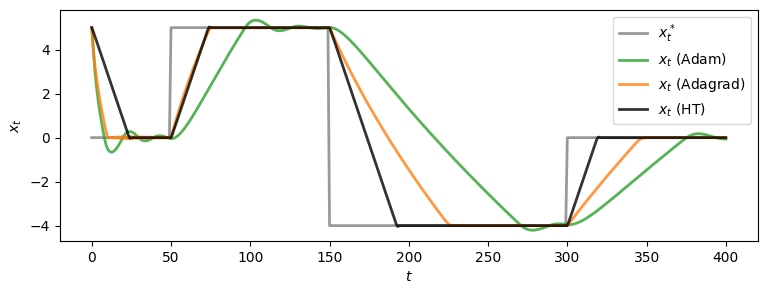

In [8]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(c_vec, color='gray', alpha=0.8)
plt.plot(x_adam, '-', color='tab:green', alpha=0.8)
plt.plot(x_adagrad, '-', color='tab:orange', alpha=0.8)
plt.plot(x_ht, '-', color='k', alpha=0.8)
plt.legend(['$x^*_t$','$x_t$ (Adam)','$x_t$ (Adagrad)','$x_t$ (HT)'])
ax.set_xlabel('$t$')
ax.set_ylabel('$x_t$')

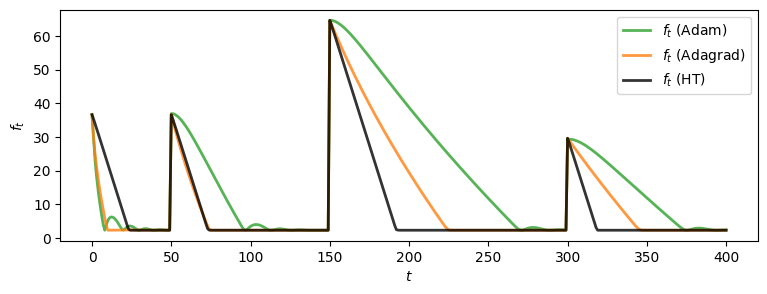

In [9]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(loss_adam, color='tab:green', alpha=0.8)
plt.plot(loss_adagrad, color='tab:orange', alpha=0.8)
plt.plot(loss_ht, color='k', alpha=0.8)
ax.set_xlabel('$t$')
ax.set_ylabel('$f_t$')
plt.legend(['$f_t$ (Adam)','$f_t$ (Adagrad)','$f_t$ (HT)'])


## Compute regret optimal values

In [10]:
a = 5
b = 7
c = 0
x = 5

learning_rate=1
iter=400
loss_values=[]
all_x=[]
all_f=[]

for i in tqdm(range(0,iter)):
  function = lambda x: cum_cost_(a,b,c_vec_,x,i)
  min_func = minimize(function, 5.0, method="BFGS", tol=1e-3)
  optimal_x = min_func.x[0]
  min_cost = min_func.fun
  all_x.append(optimal_x)
  all_f.append(min_cost)

min_cum_cost_vec=all_f #this is used for regret calculation it is the cumulative cost for the best fixed optimal value in hindsight

for i in range(iter):
    loss = cost_(a,b,c_vec[i],all_x[i])
    loss_values.append(loss)

inst_loss_with_regret_optimal=loss_values #this is a weird object, its the instantaneous cost using the regret optimal fixed cost. This doesnt mean anything


100%|█████████████████████████████████████████| 400/400 [00:47<00:00,  8.50it/s]


### plot x_t and f_t with comparison to regret optimal

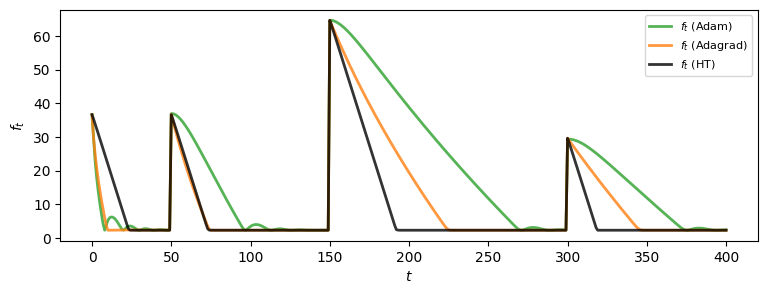

In [11]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(loss_adam, color='tab:green', alpha=0.8)
ax.plot(loss_adagrad, color='tab:orange', alpha=0.8)
ax.plot(loss_ht, color='k', alpha=0.8)
#ax.plot(inst_loss_with_regret_optimal, color='tab:pink', alpha=1)
ax.set_xlabel('$t$')
ax.set_ylabel('$f_t$')
ax.legend(['$f_t$ (Adam)','$f_t$ (Adagrad)','$f_t$ (HT)', r'$f_t(\bar x_t)$ (regret optimal)'], fontsize=8)

Text(0, 0.5, '$x_t$')

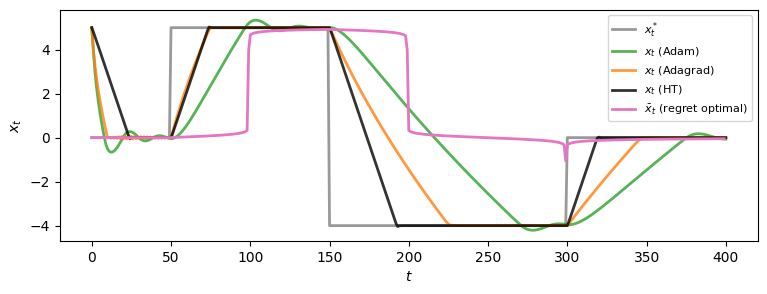

In [12]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(c_vec, color='gray', alpha=0.8)
ax.plot(x_adam, '-', color='tab:green', alpha=0.8)
ax.plot(x_adagrad, '-', color='tab:orange', alpha=0.8)
ax.plot(x_ht, color='k', alpha=0.8)
ax.plot(all_x, color='tab:pink', alpha=1)
ax.legend(['$x^*_t$','$x_t$ (Adam)','$x_t$ (Adagrad)','$x_t$ (HT)', r'$\bar x_t$ (regret optimal)'], fontsize=8)
ax.set_xlabel('$t$')
ax.set_ylabel('$x_t$')
#ax.set_ylim(-5,6)

### calculate cumulative averaege cost and average regret for methods and plot them

In [14]:
adam_cum_vec=[]
adagrad_cum_vec=[]
regret_cum_vec=[]
ht_cum_vec=[]
lb_cum_vec=[]
ave_min_cum_cost_vec=[]

adam_cum=0
adagrad_cum=0
regret_cum=0
ht_cum=0
lb_cum=0
for i in range(len(loss_values)):
  adam_cum+=loss_adam[i]
  adagrad_cum+=loss_adagrad[i]
  ht_cum+=loss_ht[i]
  lb_cum+=np.log(5)+np.log(2) #lower bound
  #min cum cost for best fixed value already calculated dont need to calculate it

  adam_cum_vec.append(adam_cum/(i+1))
  adagrad_cum_vec.append(adagrad_cum/(i+1))
  ave_min_cum_cost_vec.append(min_cum_cost_vec[i]/(i+1))
  ht_cum_vec.append(ht_cum/(i+1))
  lb_cum_vec.append(lb_cum/(i+1))


Text(0, 0.5, 'mean cost    $\\frac{1}{t}\\sum_{\\tau=1}^t f_\\tau$')

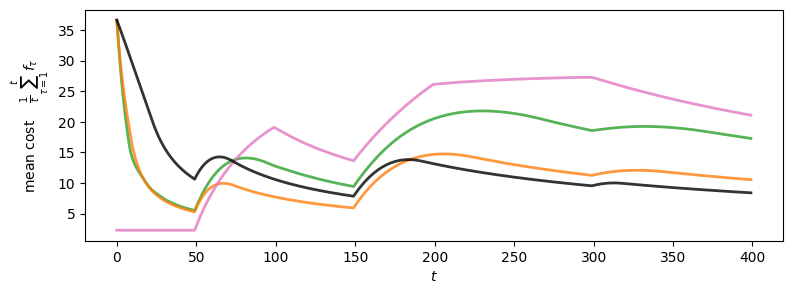

In [15]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(adam_cum_vec, color='tab:green', alpha=0.8)
ax.plot(adagrad_cum_vec, color='tab:orange', alpha=0.8)
ax.plot(ave_min_cum_cost_vec, color='tab:pink', alpha=0.8)
ax.plot(ht_cum_vec, color='k', alpha=0.8)
ax.set_xlabel('$t$')
ax.set_ylabel(r'mean cost    $\frac{1}{t}\sum_{\tau=1}^t f_\tau$')

Text(0, 0.5, 'mean regret   $\\frac{1}{T}\\cdot\\mathrm{Regret}(T)$')

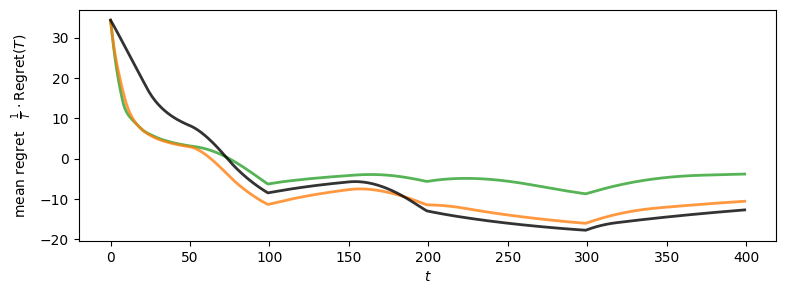

In [16]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(np.asarray(adam_cum_vec)-np.asarray(ave_min_cum_cost_vec), color='tab:green', alpha=0.8)
ax.plot(np.asarray(adagrad_cum_vec)-np.asarray(ave_min_cum_cost_vec), color='tab:orange', alpha=0.8)
ax.plot(np.asarray(ht_cum_vec)-np.asarray(ave_min_cum_cost_vec), 'k', alpha=0.8)
ax.set_xlabel('$t$')
ax.set_ylabel(r'mean regret   $\frac{1}{T}\cdot\mathrm{Regret}(T)$')

## Combined Single Plot

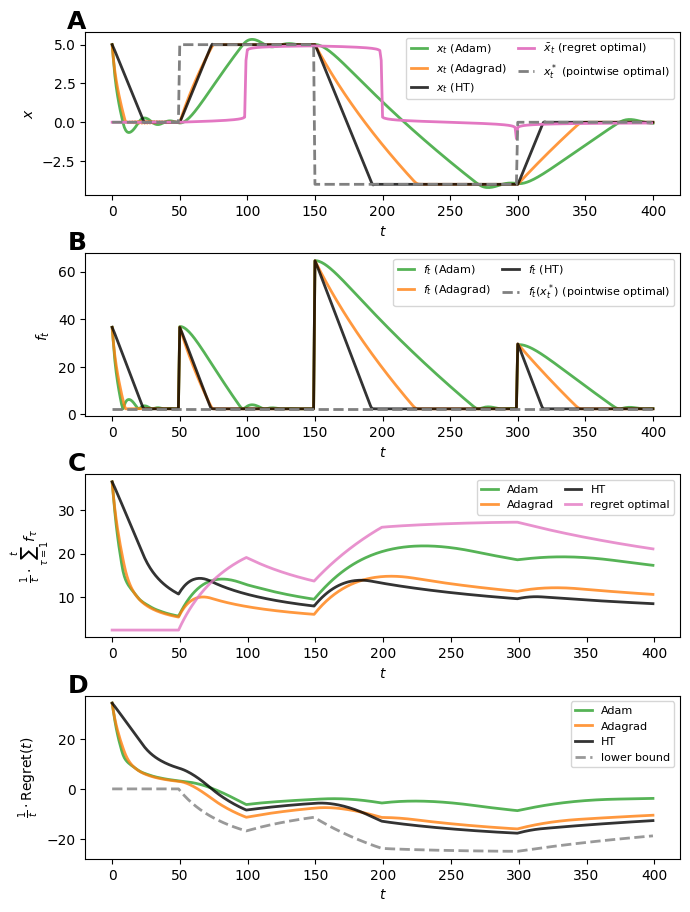

In [17]:



fig, axs = plt.subplots(4, 1, figsize=(7, 9))

ax=axs[1]
ax.plot(loss_adam, color='tab:green', alpha=0.8)
ax.plot(loss_adagrad, color='tab:orange', alpha=0.8)
ax.plot(loss_ht, color='k', alpha=0.8)
ax.plot(loss_optimal, '--', color='gray', alpha=1)
ax.set_xlabel('$t$')
ax.set_ylabel('$f_t$')
ax.legend(['$f_t$ (Adam)','$f_t$ (Adagrad)','$f_t$ (HT)', '$f_t(x^*_t)$ (pointwise optimal)'],
          ncol=2, fontsize=8, columnspacing=1, handlelength=1.5)

ax=axs[0]
ax.plot(x_adam, '-', color='tab:green', alpha=0.8)
ax.plot(x_adagrad, '-', color='tab:orange', alpha=0.8)
ax.plot(x_ht, color='k', alpha=0.8)
ax.plot(all_x, color='tab:pink', alpha=1)
ax.plot(c_vec, '--', color='gray', linewidth=2, alpha=1)
ax.legend(['$x_t$ (Adam)','$x_t$ (Adagrad)','$x_t$ (HT)', r'$\bar x_t$ (regret optimal)', '$x^*_t$ (pointwise optimal)'],
          ncol=2, fontsize=8, columnspacing=1, handlelength=1.5)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

ax=axs[2]
ax.plot(adam_cum_vec, color='tab:green', alpha=0.8)
ax.plot(adagrad_cum_vec, color='tab:orange', alpha=0.8)
ax.plot(ht_cum_vec, color='k', alpha=0.8)
ax.plot(ave_min_cum_cost_vec, color='tab:pink', alpha=0.8)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$\frac{1}{t}\cdot \sum_{\tau=1}^t f_\tau $')
ax.legend(['Adam','Adagrad','HT', 'regret optimal'], ncol=2, fontsize=8, columnspacing=1, handlelength=1.5)

ax=axs[3]
ax.plot(np.asarray(adam_cum_vec)-np.asarray(ave_min_cum_cost_vec), color='tab:green', alpha=0.8)
ax.plot(np.asarray(adagrad_cum_vec)-np.asarray(ave_min_cum_cost_vec), color='tab:orange', alpha=0.8)
ax.plot(np.asarray(ht_cum_vec)-np.asarray(ave_min_cum_cost_vec), 'k', alpha=0.8)
ax.plot(np.asarray(lb_cum_vec)-np.asarray(ave_min_cum_cost_vec), '--', color='gray', alpha=0.8)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$\frac{1}{t}\cdot\mathrm{Regret}(t)$')
ax.legend(['Adam','Adagrad','HT', 'lower bound'], fontsize=8, columnspacing=1, handlelength=1.5)


plt.tight_layout()
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.03, 1.02, string.ascii_uppercase[n], transform=ax.transAxes,
            size=18, weight='bold')

plt.savefig('results.pdf', bbox_inches='tight')

**Supplemental Figure 1. Comparison of Adam, Adagrad, and HT to the regret optimal solution ($\bar x_t$), in a scenario where optimal (pointwise) $x^*_t$ changes at $t = 50, 150, 300$.** **(A)** Optimal solutions of each method in comparison to the pointwise optimal as well as the regret optimal solution. **(B)** cost over time of the comparator methods. **(C)** Average cost over time **(D)** Average regret of the methods.